# Read list_meop.pkl and draw global maps

In [10]:
from pathlib import Path
import sys
import os
import shutil
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import gsw
from IPython.display import display,Image

import importlib
import meop
importlib.reload(meop)
processdir = meop.processdir

import meop_plot_data
importlib.reload(meop_plot_data)

import meop_read_data
importlib.reload(meop_read_data)

pass

In [11]:
list_profiles, list_tags, list_deployments = meop.read_list_profiles(rebuild=False,verbose=False,public=True,Tdata=True)

(<Figure size 720x720 with 1 Axes>,
 <cartopy.mpl.geoaxes.GeoAxesSubplot at 0x7f2367358a90>)

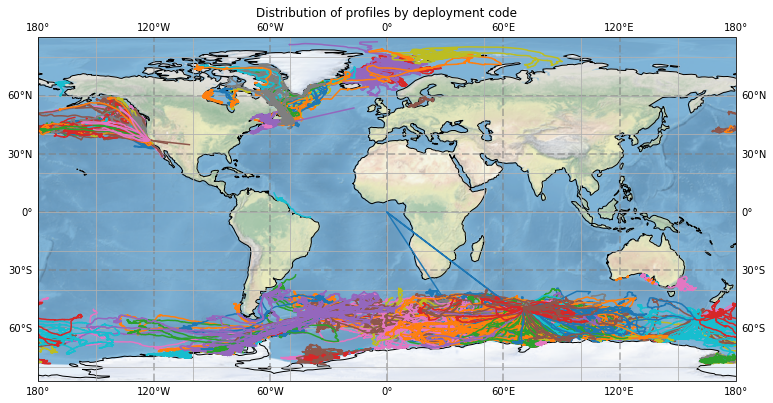

In [87]:
meop_plot_data.plot_map_deployments(list_profiles,
                          groupby='DEPLOYMENT_CODE',
                          title=f'Distribution of profiles by deployment code',
                          legend=False,
                         )

Southern Ocean       436604
North Atlantic       119054
Australia             49634
North Pacific         32755
South Atlantic         4139
Tropical Atlantic      2293
Name: MASK, dtype: int64


(<Figure size 720x720 with 1 Axes>,
 <cartopy.mpl.geoaxes.GeoAxesSubplot at 0x7ff8e2cf9390>)

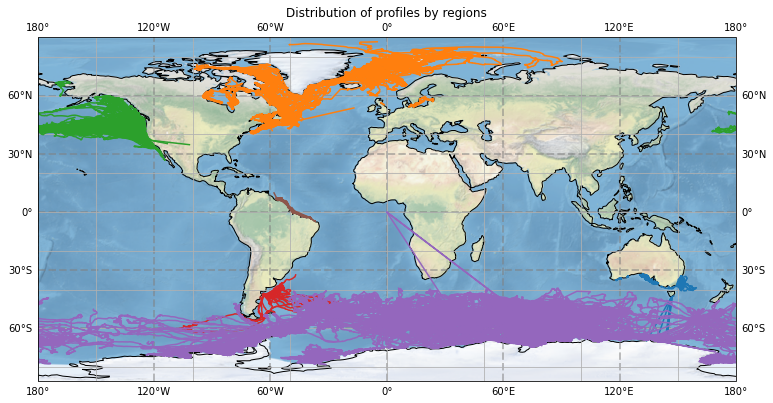

In [12]:
print(list_profiles.MASK.value_counts())
meop_plot_data.plot_map_deployments(list_profiles,
                          groupby='MASK',
                          title=f'Distribution of profiles by regions',
                          legend=False,
                         )

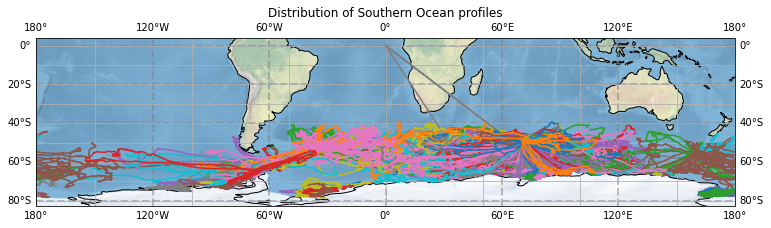

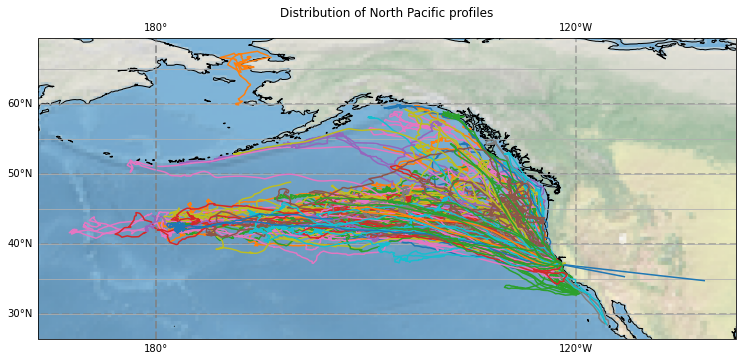

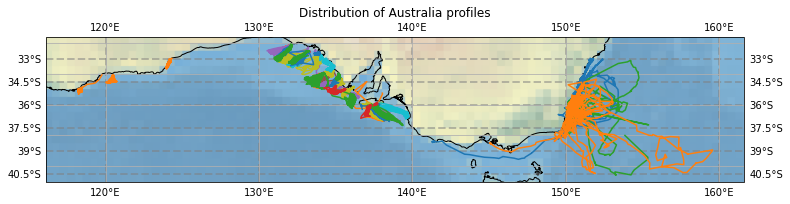

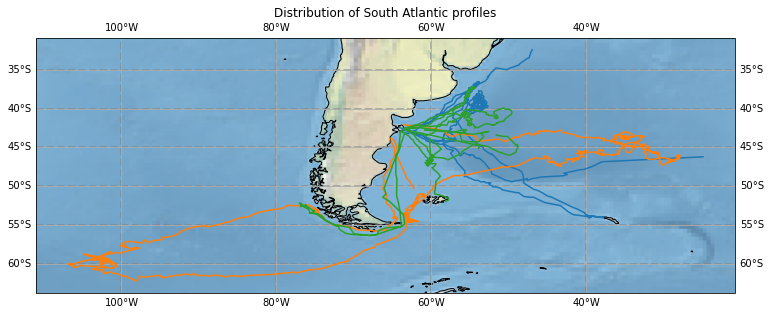

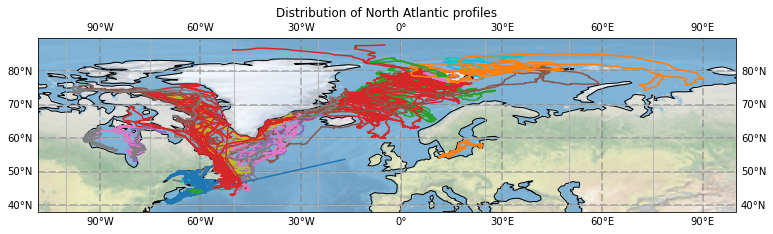

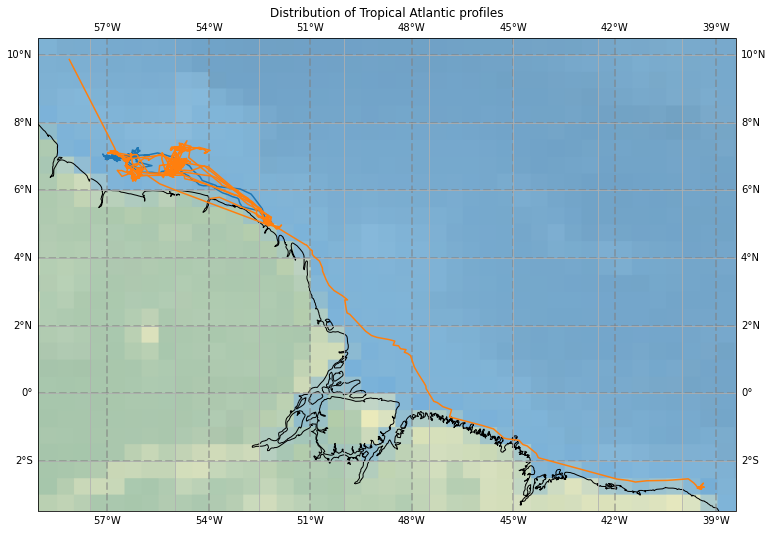

In [90]:
for region in list_tags.MASK.unique():
    index_tags = list_tags[list_tags.MASK2==region].SMRU_PLATFORM_CODE
    meop_plot_data.plot_map_deployments(list_profiles[list_profiles.SMRU_PLATFORM_CODE.isin(index_tags)],
                              groupby='DEPLOYMENT_CODE',
                              title=f'Distribution of {region} profiles',
                              legend=False,
                             )

(<Figure size 720x720 with 1 Axes>,
 <cartopy.mpl.geoaxes.GeoAxesSubplot at 0x7f236ed72110>)

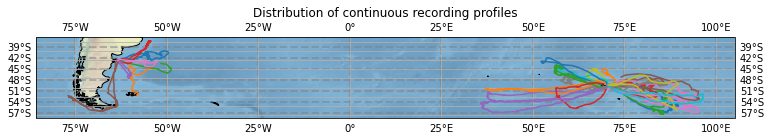

In [20]:
if 'continuous' not in list_profiles:
    list_profiles = list_profiles.merge(list_tags.set_index('SMRU_PLATFORM_CODE').continuous,on='SMRU_PLATFORM_CODE')
list_profiles_continuous = list_profiles.loc[list_profiles.continuous==1,:]

meop_plot_data.plot_map_deployments(list_profiles_continuous,
                          groupby='SMRU_PLATFORM_CODE',
                          title=f'Distribution of continuous recording profiles',
                          legend=False,
                          namefig='global_map_continuous_profiles.png'
                         )

/home/jupyter-froqu/GitHub/meop_qc/python_toolbox/meop_plot_data.py:224: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


(<Figure size 720x720 with 1 Axes>,
 <cartopy.mpl.geoaxes.GeoAxesSubplot at 0x7f23780f2f10>)

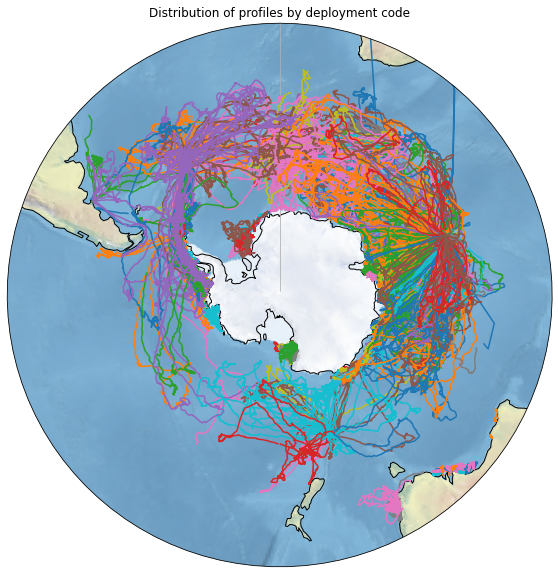

In [24]:
importlib.reload(meop_plot_data)
meop_plot_data.plot_map_stereo_south(list_profiles,
                          groupby='DEPLOYMENT_CODE',
                          title=f'Distribution of profiles by deployment code',
                          legend=False,
                         )

(<Figure size 720x720 with 1 Axes>,
 <cartopy.mpl.geoaxes.GeoAxesSubplot at 0x7f235d11db10>)

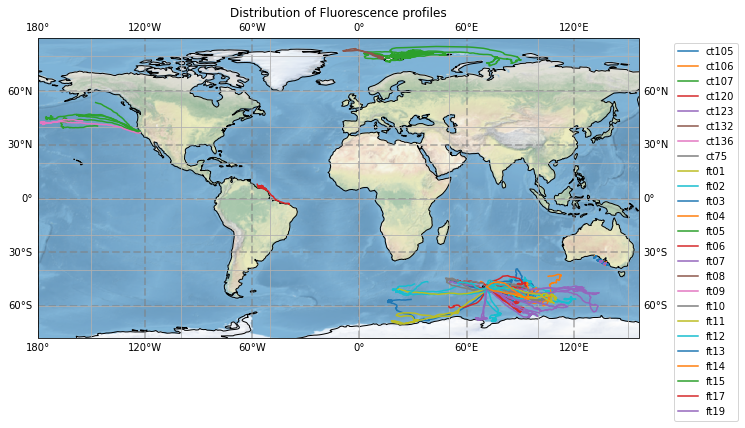

In [92]:
meop_plot_data.plot_map_deployments(list_profiles[list_profiles.N_CHLA>0],
                                    groupby='DEPLOYMENT_CODE',
                                    title='Distribution of Fluorescence profiles',
                                    namefig='global_map_chla_profiles.png')